In [41]:
%matplotlib inline
#
from os import chdir, getcwd
ROOTF = 'LRG-Signed'
if getcwd()[-len(ROOTF):] != ROOTF:
    chdir('../')
print('cwd:', getcwd())
#
from src.LRGSG_package.LRGSG import *

cwd: /home/opisthofulax/PhD/projects/complex-networks/LRG-Signed


### Coordinates mapping between flat and bidimensional graph node indexing
Mapping between $2D$ coordinates of the NetworkX grid $\mathcal{G}$ and $\mathbb{N}^+$ labeled version $\mathcal{H}$, either in absence of BC and with PBC.

In [64]:
# parameters
initial_cond = 'ground_state_0'
BC_choice = 'PBC'
#
L = 40
t_steps = 10
no_obs = 5
fbc_val = 1
#
Deltat = 1/t_steps
simulationTime = L**2*t_steps
sampling = 1*t_steps
frames = simulationTime // sampling

$\dot{x}(t) = -\bar{L}x(t)$<br>
$x(t+\Delta t) = x(t) - \Delta t\bar{L}x(t)$<br>
$y(t) = e^{-\lambda_0 t}x(t)$<br>
$\dot{y}(t) = e^{-\lambda_0 t}\dot{x}(t) -\lambda_0e^{-\lambda_0 t}x(t)$<br>
$\dot{y}(t) = -e^{-\lambda_0 t}\bar{L}x(t) -\lambda_0e^{-\lambda_0 t}x(t)$<br>
$\dot{y}(t) = -(\bar{L} + \lambda_0)y(t)$<br>
$y(t+\Delta t) = y(t)  -\Delta t(\bar{L} + \lambda_0)y(t)$

In [65]:
neg_weightsG = {((L//2,L//2), (L//2,L//2+1)): -1}
# neg_weightsH = {(0, 10): -1}
fraction_to_flip = 0.05
#
G = nx.grid_2d_graph(L, L, periodic=True if BC_choice == 'PBC' else False)
nx.set_edge_attributes(G, values=1, name='weight')
nx.set_edge_attributes(G, values=neg_weightsG, name='weight')
# flip_random_fract_edges(G, fraction_to_flip)
H = nx.convert_node_labels_to_integers(G)
# nx.set_edge_attributes(H, values=neg_weightsH, name='weight')
#
neighbor_dictG = nx.single_source_shortest_path_length(G, (0, 0))
neighbor_dictH = nx.single_source_shortest_path_length(H, 0)
#
Gedges = list(G.edges(data=True))
neg_weightsG = [i for i in Gedges if i[2]['weight'] == -1]
Hedges = list(H.edges(data=True))
neg_weightsH = [i for i in Hedges if i[2]['weight'] == -1]
#
print('Flipped edges:', '\nG graph', neg_weightsG, '\nH graph', neg_weightsH, '[+ G negative edges]')

Flipped edges: 
G graph [((20, 20), (20, 21), {'weight': -1})] 
H graph [(820, 821, {'weight': -1})] [+ G negative edges]


In [66]:
node_map = dict(zip(H, G))
edge_map = dict(zip(H.edges(), G.edges()))

In [67]:
# laplacian and signed laplacian matrix
adj = nx.adjacency_matrix(G).toarray()
dia = np.diag(adj.sum(axis=1))
lapl = dia - adj
diabs = np.diag(np.abs(adj).sum(axis=1))
slapl = diabs - adj
eigv, eigV = np.linalg.eigh(slapl)

In [68]:
# plotGraph = H
# edge_list, weights = zip(*nx.get_edge_attributes(plotGraph,'weight').items())
# edge_color = ['r' if w == -1 else 'k' for w in weights]
# node_color = ['red' if eigV[i,0] > 0 else 'blue' for i in H.nodes()] 
# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
# pos = dict(zip(plotGraph,G))
# pos_dict = {k: np.array(v) for k,v in pos.items()}

# nx.draw(plotGraph, pos, node_color=node_color, edgelist=edge_list, edge_color=edge_color, node_size=100, ax=ax1, node_shape="s")
# nx.draw(plotGraph, pos, ax=ax2, node_color='lightblue', edgelist=edge_list, edge_color=edge_color, node_size=0, width=5)

In [76]:
if initial_cond == 'uniform_1':
    status_array = np.random.uniform(-1, 1, L**2)#np.ones(L**2)
elif initial_cond == 'delta_1':
    status_array = np.zeros(L**2)
    status_array[L**2//2] = L**2
elif initial_cond == 'gauss_1':
    status_array = np.random.normal(0, 1, L**2)
elif initial_cond.startswith('ground_state'):
    eigenMode = int(initial_cond.split('_')[-1])
    status_array = eigV[:, 0]
#
if BC_choice == 'FBC':
    # fixed_indices = np.array(list(set(
    #                   np.concatenate([[i for i in range(L)], 
    #                         [i for i in range(L**2) if i % L ==0], 
    #                         [i for i in range(L**2) if (i+1) % (L) ==0],
    #                         [i for i in range(L**2-L, L**2)]]))))
    fixed_border_idxs = np.array(sorted([i for i in range(L)] + \
                [(L-1) * L + i for i in range(L)] + \
                [i * L for i in range(1, L-1)] + 
                [(i+1) * L - 1 for i in range(1, L-1)]))
    status_array[fixed_border_idxs] = fbc_val

In [77]:
# morans_i = np.array([local_moran_i(i, status_array, adj) for i in range(len(status_array))])
# plt.imshow(morans_i.reshape(L, L)/L**2)
# plt.colorbar()

In [78]:
frames_dynsys = []

In [82]:
for t in range(simulationTime):
    status_array_old = status_array
    if ((t) % sampling == 0):
        print(t, np.mean(status_array), np.var(status_array))
        frames_dynsys.append(status_array_old.reshape(L, L))
    status_array = status_array - Deltat*(slapl@status_array) #+ np.sqrt(Deltat)*np.random.uniform(-1e-3, 1e-3, L**2)
    # status_array[fixed_border_idxs] = fbc_val
    # if (np.abs(status_array_old - status_array) < 1e-7*np.ones(L**2)).all():
    #     print('Convergence rea\ched')
    #     break

0 -0.02157429883982025 3.2302201362074348e-06
10 -0.021556704731493282 3.2249537153171016e-06
20 -0.021539124971379903 3.21969588058741e-06
30 -0.02152155954777897 3.2144466180198278e-06
40 -0.02150400844899888 3.209205913638647e-06
50 -0.021486471663357563 3.203973753490947e-06
60 -0.02146894917918247 3.1987501236465506e-06
70 -0.021451440984810582 3.1935350101979962e-06
80 -0.021433947068588387 3.1883283992604942e-06
90 -0.021416467418871887 3.1831302769718934e-06
100 -0.021399002024026555 3.1779406294926424e-06
110 -0.021381550872427373 3.1727594430057525e-06
120 -0.0213641139524588 3.1675867037167624e-06
130 -0.02134669125251476 3.1624223978537015e-06
140 -0.021329282760998644 3.1572665116670503e-06
150 -0.02131188846632331 3.1521190314297074e-06
160 -0.02129450835691106 3.1469799434369533e-06
170 -0.021277142421193627 3.141849234006409e-06
180 -0.021259790647612187 3.1367268894780036e-06
190 -0.021242453024617355 3.131612896213938e-06
200 -0.02122512954066914 3.126507240598646e-06

KeyboardInterrupt: 

In [83]:
status = status_array.reshape(L, L)
halfsize = L//2
hcut_halfsize = status[:, halfsize]
critrad = np.sqrt(1.128/(3.14*0.103))
ball_halfsizeM = halfsize-critrad
ball_halfsizeP = halfsize+critrad

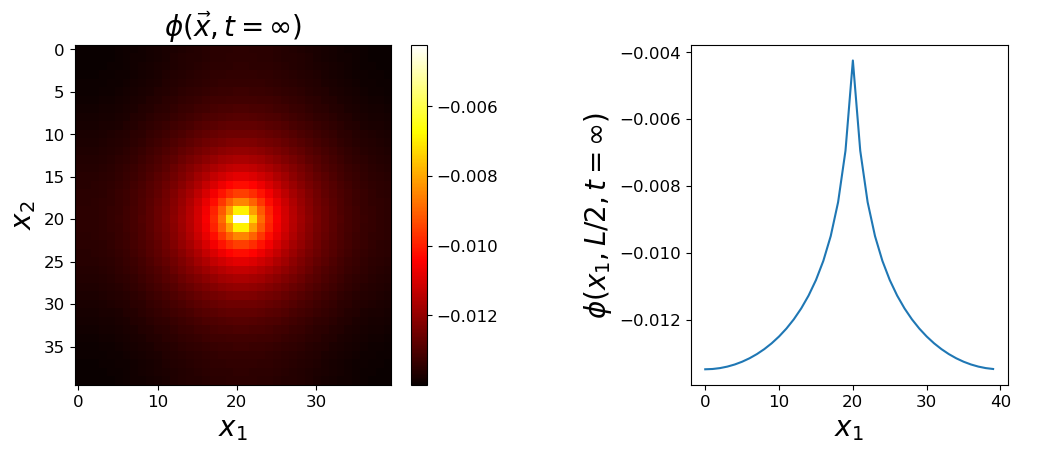

In [84]:


plt.rc('font', size=12)
plt.rc('axes', labelsize=20)
plt.rc('axes', titlesize=20)
cax_dict = {"size": "5%", "pad":0.2}
axvline_cr = {"ls": ":", "color": "red"}
# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
fig = plt.figure(figsize=(12, 6))
#
#
ax1 = plt.subplot(121)
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
ax1.set_title(r"$\phi(\vec{x}, t=\infty)$")
#
im1 = ax1.imshow(status, cmap=plt.cm.hot, aspect="auto")
#
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", **cax_dict)
clb = fig.colorbar(im1, cax=cax)
#
#
ax2 = plt.subplot(122)
ax2.set_xlabel("$x_1$")
ax2.set_ylabel(r"$\phi(x_1, L/2, t=\infty)$")
#
ax2.plot(hcut_halfsize)
# ax2.axvline(ball_halfsizeM, **axvline_cr)
# ax2.axvline(ball_halfsizeP, **axvline_cr)
#
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", **cax_dict)
cax2.axis('off')
#
trans = ax2.get_xaxis_transform()
# ax2.text(ball_halfsizeM, 1.01, r'$L/2 \pm r_{\rm c}$', color='red', horizontalalignment='center', transform=trans)

#
# # ax2.set_xscale('log')
# aspect_ratio = ax1.get_data_ratio() / ax2.get_data_ratio()
# box_ratio = 1.0
# ax2.set_aspect(aspect_ratio)
fig.tight_layout(pad=5.0)

In [1]:
x = np.linspace(0, 1)
plt.plot(hcut_halfsize[50:60], 'o')
plt.plot(x, hcut_halfsize[50]*(np.exp(x/(2*critrad))), label=r'$\propto e^{d/r_{\rm c}}$')
plt.axhline(hcut_halfsize[60])
plt.yscale('log')
plt.xlabel(r"distance from perturbation $d$")
plt.ylabel("field value")
plt.legend()

NameError: name 'np' is not defined

In [321]:
hcut_halfsize[50]

7728.881604006195

In [175]:
gridspec[0], gridspec[1]

(GridSpec(1, 2)[0:1, 0:1], GridSpec(1, 2)[0:1, 1:2])

In [159]:
ax1.get_xlim()

(-0.5, 99.5)

In [77]:
rcorr = np.array(radial_correlation(status_array, neighbor_dictH, 5050))

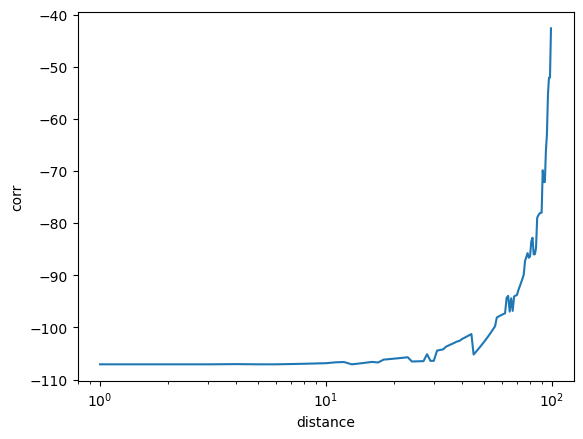

In [78]:
plt.plot(rcorr[:, 0], rcorr[:, 1])
plt.xlabel('distance')
plt.ylabel('corr')
plt.xscale('log')


________________________________________________________________________________

In [79]:
L = 40
neg_weights = {((2,2), (2,3)): -1}

G = nx.grid_2d_graph(L, L, periodic=True)
nx.set_edge_attributes(G, values=1, name='weight')
# nx.set_edge_attributes(G, values=neg_weights, name='weight')
#oppure
fraction_to_flip = 160/1600
flip_random_fract_edges(G, fraction_to_flip)
H = nx.convert_node_labels_to_integers(G)

In [80]:
# laplacian and signed laplacian matrix
adj = nx.adjacency_matrix(G).toarray()
dia = np.diag(adj.sum(axis=1))
lapl = dia - adj
diabs = np.diag(np.abs(adj).sum(axis=1))
slapl = diabs - adj
eigv, eigV = np.linalg.eigh(slapl)

In [81]:
pos = dict(zip(G,H))

In [82]:
Gedges = list(G.edges(data=True))
Hedges = [(pos[ge1], pos[ge2], gw) for ge1, ge2, gw in Gedges]

In [83]:
# Hedgelist = list(H.edges(data=True))
# sorted_list = sorted(Hedgelist, key=lambda x: (x[0], x[1]))

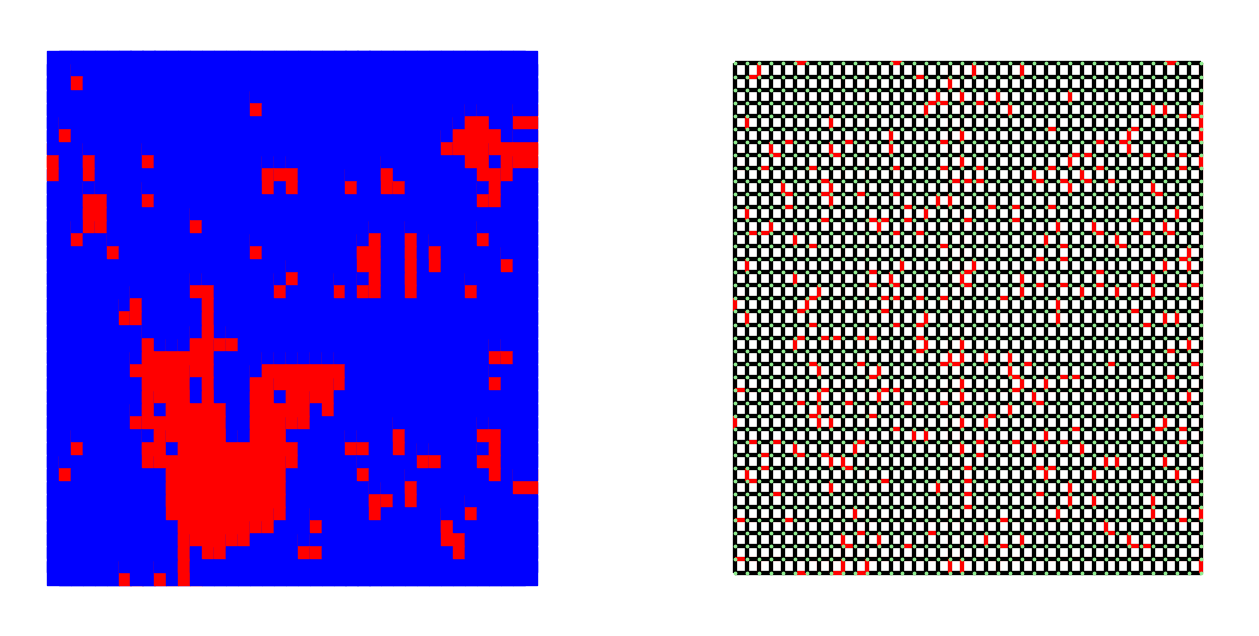

In [84]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
posH = {i:(x, y) for i,(x,y) in enumerate(product(range(L), range(L)))}
posG = {(x, y):(x, y) for i,(x,y) in enumerate(product(range(L), range(L)))}
node_color = ['red' if eigV[i,0] > 0 else 'blue' for i in H.nodes()] 
edge_colorH = ['red' if d['weight'] == -1 else 'black' for u,v,d in Hedges]
edge_colorG = ['red' if d['weight'] == -1 else 'black' for u,v,d in Gedges]
nx.draw(H, node_color=node_color, pos=posH, ax=ax1, node_shape="s")
nx.draw(G, node_size=3, node_color='lightgreen', pos=posG, edge_color = edge_colorG,  width=3, ax=ax2)

In [114]:
L = 8
no_obs = 5
T_STEPS = 100000
Deltat = 1/T_STEPS
sampling = T_STEPS//no_obs
initial_cond = 'delta_1'
# coord1, coord2 = 0, 1# flip_random_fract_edges(G, 1/G.number_of_edges())
G = nx.grid_2d_graph(L, L)
# pos = dict(zip(G,G)) # dictionary of node names->positions
# #
# nx.set_node_attributes(G, pos, 'pos')
# #
all_weights = {e: 1 for e in G.edges()}
neg_weights = {((0, 0), (0, 1)): -1}
nx.set_edge_attributes(G, values=all_weights, name='weight')
nx.set_edge_attributes(G, values=neg_weights, name='weight')
# flip_random_fract_edges(G, 10/G.number_of_edges())
# flip_one_2dgraph(G, coord1, coord2)
# arr = nx.to_scipy_sparse_array(G, format="csr").todense()# for t in range(1000)
adj = nx.adjacency_matrix(G).toarray()
dia = np.diag(adj.sum(axis=1))
lapl = dia - adj
diabs = np.diag(np.abs(adj).sum(axis=1))
slapl = diabs - adj
eigv, eigV = np.linalg.eig(lapl)

In [74]:
lapl

array([[ 0,  1,  0, ...,  0,  0,  0],
       [ 1,  1, -1, ...,  0,  0,  0],
       [ 0, -1,  3, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  3, -1,  0],
       [ 0,  0,  0, ..., -1,  3, -1],
       [ 0,  0,  0, ...,  0, -1,  2]])

In [75]:
eigv, eigV = np.linalg.eig(lapl)
eigV[:,0]

array([-7.90168330e-01,  5.40739684e-01,  1.66876100e-01,  5.42576965e-02,
        1.83612371e-02,  6.42851992e-03,  2.38316232e-03,  1.12192989e-03,
       -1.92120091e-01,  8.52167005e-02,  6.04039922e-02,  2.78582998e-02,
        1.14270462e-02,  4.50343884e-03,  1.80935581e-03,  9.01257121e-04,
       -4.95948350e-02,  1.08794032e-02,  1.76879393e-02,  1.11822846e-02,
        5.58348572e-03,  2.52565125e-03,  1.12769359e-03,  6.08377288e-04,
       -1.35416871e-02,  2.98160635e-04,  4.69116283e-03,  3.97068064e-03,
        2.37749287e-03,  1.23046017e-03,  6.13295329e-04,  3.60434652e-04,
       -3.88793588e-03, -5.59700463e-04,  1.15879751e-03,  1.31448121e-03,
        9.30405366e-04,  5.46619763e-04,  3.03407755e-04,  1.93924740e-04,
       -1.16837552e-03, -3.26931175e-04,  2.63999852e-04,  4.17187112e-04,
        3.45953459e-04,  2.29180825e-04,  1.41193682e-04,  9.77917690e-05,
       -3.73896244e-04, -1.46868398e-04,  5.17986912e-05,  1.31243702e-04,
        1.27903016e-04,  

In [76]:
list(G.edges(data=True))
edge_color = ['red' if d['weight'] == 1 else 'black' for u,v,d in list(G.edges(data=True))]

In [77]:
edge_color = ['red' if d['weight'] == -1 else 'black' for u,v,d in sorted_list]

NameError: name 'sorted_list' is not defined

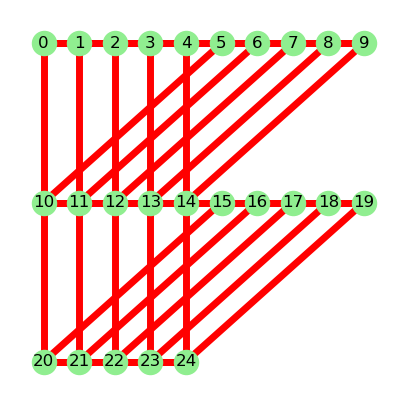

In [133]:


# coord1, coord2 = (1, 3), (2, 3)
neg_weights = {(0, 5): -1}
G = nx.grid_2d_graph(5,5, periodic=True)
# pos = dict(zip(G,G)) # dictionary of node names->positions
# print(pos)
#
# nx.set_node_attributes(G, pos, 'pos')
#
G = nx.convert_node_labels_to_integers(G)
nx.set_edge_attributes(G, values=1, name='weight')
nx.set_edge_attributes(G, values=neg_weights, name='weight')
# print(list(G.edges(data=True)))
# labeldict = {i: e for i, e in enumerate(G.nodes())}
fig, ax = plt.subplots(figsize=(5, 5))
# node_colors = "lightblue"
# edges = G.edges()
# for u,v in edges:
#     G[u][v]['color'] = 'red' if G[u][v]['weight'] == 1 else 'blue'
# colors = [G[u][v]['color'] for u,v in edges]
# # edge_colors = ["blue" if n[0]n[1]['weight'] == 1 else "red" for n in G.edges(data=True)]
# pos = nx.get_node_attributes(G,'pos')
# nx.draw(G, pos=pos, labels=labeldict, with_labels=True,  edge_color=colors, node_color = node_colors, width = 3, ax=ax)
# plt.show()
edge_color = ['red' if d['weight'] == 1 else 'black' for u,v,d in G.edges(data=True)] ## uni-directional edges will be red and bi-directional ones will be black

pos = {(x,y):(y,-x) for x,y in product(range(L), range(L))}
pos1 = {i: value for i, value in zip(range(L**2), pos.values())}## assign the nodes to their positions

nx.draw(G,node_size=300,node_color='lightgreen', with_labels=True, pos=pos1, width=5, edge_color = edge_color,ax=ax)

In [132]:
pos1

{0: (0, 0),
 1: (1, -1),
 2: (2, -2),
 3: (3, -3),
 4: (4, -4),
 5: (5, -5),
 6: (6, -6),
 7: (7, -7),
 8: (8, -8),
 9: (9, -9)}

In [124]:
a, b, c = list(G.edges(data=True))[0]

In [126]:
c

{'weight': -1}

In [99]:
G.edges(data=True)

EdgeDataView([(0, 5, {'weight': 1}), (0, 1, {'weight': 1}), (0, 20, {'weight': 1}), (0, 4, {'weight': 1}), (1, 6, {'weight': 1}), (1, 2, {'weight': 1}), (1, 21, {'weight': 1}), (2, 7, {'weight': 1}), (2, 3, {'weight': 1}), (2, 22, {'weight': 1}), (3, 8, {'weight': 1}), (3, 4, {'weight': 1}), (3, 23, {'weight': 1}), (4, 9, {'weight': 1}), (4, 24, {'weight': 1}), (5, 10, {'weight': 1}), (5, 6, {'weight': 1}), (5, 9, {'weight': 1}), (6, 11, {'weight': 1}), (6, 7, {'weight': 1}), (7, 12, {'weight': 1}), (7, 8, {'weight': 1}), (8, 13, {'weight': 1}), (8, 9, {'weight': 1}), (9, 14, {'weight': 1}), (10, 15, {'weight': 1}), (10, 11, {'weight': 1}), (10, 14, {'weight': -1}), (11, 16, {'weight': 1}), (11, 12, {'weight': 1}), (12, 17, {'weight': 1}), (12, 13, {'weight': 1}), (13, 18, {'weight': 1}), (13, 14, {'weight': 1}), (14, 19, {'weight': 1}), (15, 20, {'weight': 1}), (15, 16, {'weight': 1}), (15, 19, {'weight': 1}), (16, 21, {'weight': 1}), (16, 17, {'weight': 1}), (17, 22, {'weight': 1}), 

In [98]:
G.edges(data=True)

EdgeDataView([(0, 5, {'weight': 1}), (0, 1, {'weight': 1}), (0, 20, {'weight': 1}), (0, 4, {'weight': 1}), (1, 6, {'weight': 1}), (1, 2, {'weight': 1}), (1, 21, {'weight': 1}), (2, 7, {'weight': 1}), (2, 3, {'weight': 1}), (2, 22, {'weight': 1}), (3, 8, {'weight': 1}), (3, 4, {'weight': 1}), (3, 23, {'weight': 1}), (4, 9, {'weight': 1}), (4, 24, {'weight': 1}), (5, 10, {'weight': 1}), (5, 6, {'weight': 1}), (5, 9, {'weight': 1}), (6, 11, {'weight': 1}), (6, 7, {'weight': 1}), (7, 12, {'weight': 1}), (7, 8, {'weight': 1}), (8, 13, {'weight': 1}), (8, 9, {'weight': 1}), (9, 14, {'weight': 1}), (10, 15, {'weight': 1}), (10, 11, {'weight': 1}), (10, 14, {'weight': -1}), (11, 16, {'weight': 1}), (11, 12, {'weight': 1}), (12, 17, {'weight': 1}), (12, 13, {'weight': 1}), (13, 18, {'weight': 1}), (13, 14, {'weight': 1}), (14, 19, {'weight': 1}), (15, 20, {'weight': 1}), (15, 16, {'weight': 1}), (15, 19, {'weight': 1}), (16, 21, {'weight': 1}), (16, 17, {'weight': 1}), (17, 22, {'weight': 1}), 

In [90]:
labeldict

{(0, 5): '0',
 (0, 1): '1',
 (0, 20): '2',
 (0, 4): '3',
 (1, 6): '4',
 (1, 2): '5',
 (1, 21): '6',
 (2, 7): '7',
 (2, 3): '8',
 (2, 22): '9',
 (3, 8): '10',
 (3, 4): '11',
 (3, 23): '12',
 (4, 9): '13',
 (4, 24): '14',
 (5, 10): '15',
 (5, 6): '16',
 (5, 9): '17',
 (6, 11): '18',
 (6, 7): '19',
 (7, 12): '20',
 (7, 8): '21',
 (8, 13): '22',
 (8, 9): '23',
 (9, 14): '24',
 (10, 15): '25',
 (10, 11): '26',
 (10, 14): '27',
 (11, 16): '28',
 (11, 12): '29',
 (12, 17): '30',
 (12, 13): '31',
 (13, 18): '32',
 (13, 14): '33',
 (14, 19): '34',
 (15, 20): '35',
 (15, 16): '36',
 (15, 19): '37',
 (16, 21): '38',
 (16, 17): '39',
 (17, 22): '40',
 (17, 18): '41',
 (18, 23): '42',
 (18, 19): '43',
 (19, 24): '44',
 (20, 21): '45',
 (20, 24): '46',
 (21, 22): '47',
 (22, 23): '48',
 (23, 24): '49'}

In [67]:
list(G.nodes(data=True))

[(0, {'pos': (0, 0), 'origin': (0, 0)}),
 (1, {'pos': (0, 1), 'origin': (0, 1)}),
 (2, {'pos': (0, 2), 'origin': (0, 2)}),
 (3, {'pos': (0, 3), 'origin': (0, 3)}),
 (4, {'pos': (0, 4), 'origin': (0, 4)}),
 (5, {'pos': (1, 0), 'origin': (1, 0)}),
 (6, {'pos': (1, 1), 'origin': (1, 1)}),
 (7, {'pos': (1, 2), 'origin': (1, 2)}),
 (8, {'pos': (1, 3), 'origin': (1, 3)}),
 (9, {'pos': (1, 4), 'origin': (1, 4)}),
 (10, {'pos': (2, 0), 'origin': (2, 0)}),
 (11, {'pos': (2, 1), 'origin': (2, 1)}),
 (12, {'pos': (2, 2), 'origin': (2, 2)}),
 (13, {'pos': (2, 3), 'origin': (2, 3)}),
 (14, {'pos': (2, 4), 'origin': (2, 4)}),
 (15, {'pos': (3, 0), 'origin': (3, 0)}),
 (16, {'pos': (3, 1), 'origin': (3, 1)}),
 (17, {'pos': (3, 2), 'origin': (3, 2)}),
 (18, {'pos': (3, 3), 'origin': (3, 3)}),
 (19, {'pos': (3, 4), 'origin': (3, 4)}),
 (20, {'pos': (4, 0), 'origin': (4, 0)}),
 (21, {'pos': (4, 1), 'origin': (4, 1)}),
 (22, {'pos': (4, 2), 'origin': (4, 2)}),
 (23, {'pos': (4, 3), 'origin': (4, 3)}),
 (

In [65]:
G.edges(data=True)

EdgeDataView([(0, 5, {'weight': 1}), (0, 1, {'weight': 1}), (0, 20, {'weight': 1}), (0, 4, {'weight': 1}), (1, 6, {'weight': 1}), (1, 2, {'weight': 1}), (1, 21, {'weight': 1}), (2, 7, {'weight': 1}), (2, 3, {'weight': 1}), (2, 22, {'weight': 1}), (3, 8, {'weight': 1}), (3, 4, {'weight': 1}), (3, 23, {'weight': 1}), (4, 9, {'weight': 1}), (4, 24, {'weight': 1}), (5, 10, {'weight': 1}), (5, 6, {'weight': 1}), (5, 9, {'weight': -1}), (6, 11, {'weight': 1}), (6, 7, {'weight': 1}), (7, 12, {'weight': 1}), (7, 8, {'weight': 1}), (8, 13, {'weight': 1}), (8, 9, {'weight': 1}), (9, 14, {'weight': 1}), (10, 15, {'weight': 1}), (10, 11, {'weight': 1}), (10, 14, {'weight': 1}), (11, 16, {'weight': 1}), (11, 12, {'weight': 1}), (12, 17, {'weight': 1}), (12, 13, {'weight': 1}), (13, 18, {'weight': 1}), (13, 14, {'weight': 1}), (14, 19, {'weight': 1}), (15, 20, {'weight': 1}), (15, 16, {'weight': 1}), (15, 19, {'weight': 1}), (16, 21, {'weight': 1}), (16, 17, {'weight': 1}), (17, 22, {'weight': 1}), 

In [61]:
pos

{0: (0, 0),
 1: (0, 1),
 2: (0, 2),
 3: (0, 3),
 4: (0, 4),
 5: (1, 0),
 6: (1, 1),
 7: (1, 2),
 8: (1, 3),
 9: (1, 4),
 10: (2, 0),
 11: (2, 1),
 12: (2, 2),
 13: (2, 3),
 14: (2, 4),
 15: (3, 0),
 16: (3, 1),
 17: (3, 2),
 18: (3, 3),
 19: (3, 4),
 20: (4, 0),
 21: (4, 1),
 22: (4, 2),
 23: (4, 3),
 24: (4, 4)}

In [59]:
list(G.edges())

[(0, 5),
 (0, 1),
 (0, 20),
 (0, 4),
 (1, 6),
 (1, 2),
 (1, 21),
 (2, 7),
 (2, 3),
 (2, 22),
 (3, 8),
 (3, 4),
 (3, 23),
 (4, 9),
 (4, 24),
 (5, 10),
 (5, 6),
 (5, 9),
 (6, 11),
 (6, 7),
 (7, 12),
 (7, 8),
 (8, 13),
 (8, 9),
 (9, 14),
 (10, 15),
 (10, 11),
 (10, 14),
 (11, 16),
 (11, 12),
 (12, 17),
 (12, 13),
 (13, 18),
 (13, 14),
 (14, 19),
 (15, 20),
 (15, 16),
 (15, 19),
 (16, 21),
 (16, 17),
 (17, 22),
 (17, 18),
 (18, 23),
 (18, 19),
 (19, 24),
 (20, 21),
 (20, 24),
 (21, 22),
 (22, 23),
 (23, 24)]

In [57]:
node = 0

# Set the desired order
order = 1

# Get the kth-order neighbors
neighbor_dict = nx.single_source_shortest_path_length(G, node, cutoff=order)
# Extract the nodes at the kth order
kth_order_neighbors = [n for n, d in neighbor_dict.items() if d == order]
kth_order_neighbors

[1, 4, 20, 5]

In [32]:
G.edges()

EdgeView([(0, 5), (0, 1), (1, 6), (1, 2), (2, 7), (2, 3), (3, 8), (3, 4), (4, 9), (5, 10), (5, 6), (6, 11), (6, 7), (7, 12), (7, 8), (8, 13), (8, 9), (9, 14), (10, 15), (10, 11), (11, 16), (11, 12), (12, 17), (12, 13), (13, 18), (13, 14), (14, 19), (15, 20), (15, 16), (16, 21), (16, 17), (17, 22), (17, 18), (18, 23), (18, 19), (19, 24), (20, 21), (21, 22), (22, 23), (23, 24)])

In [42]:
all_weights, neg_weights

({(0, 5): 1,
  (0, 1): 1,
  (1, 6): 1,
  (1, 2): 1,
  (2, 7): 1,
  (2, 3): 1,
  (3, 8): 1,
  (3, 4): 1,
  (4, 9): 1,
  (5, 10): 1,
  (5, 6): 1,
  (6, 11): 1,
  (6, 7): 1,
  (7, 12): 1,
  (7, 8): 1,
  (8, 13): 1,
  (8, 9): 1,
  (9, 14): 1,
  (10, 15): 1,
  (10, 11): 1,
  (11, 16): 1,
  (11, 12): 1,
  (12, 17): 1,
  (12, 13): 1,
  (13, 18): 1,
  (13, 14): 1,
  (14, 19): 1,
  (15, 20): 1,
  (15, 16): 1,
  (16, 21): 1,
  (16, 17): 1,
  (17, 22): 1,
  (17, 18): 1,
  (18, 23): 1,
  (18, 19): 1,
  (19, 24): 1,
  (20, 21): 1,
  (21, 22): 1,
  (22, 23): 1,
  (23, 24): 1},
 {(0, 1): -1})

In [29]:
nx.set_edge_attributes(G, values=all_weights, name='weight')
print(list(G.edges(data=True)))

[(0, 5, {'weight': 1}), (0, 1, {'weight': 1}), (1, 6, {'weight': 1}), (1, 2, {'weight': 1}), (2, 7, {'weight': 1}), (2, 3, {'weight': 1}), (3, 8, {'weight': 1}), (3, 4, {'weight': 1}), (4, 9, {'weight': 1}), (5, 10, {'weight': 1}), (5, 6, {'weight': 1}), (6, 11, {'weight': 1}), (6, 7, {'weight': 1}), (7, 12, {'weight': 1}), (7, 8, {'weight': 1}), (8, 13, {'weight': 1}), (8, 9, {'weight': 1}), (9, 14, {'weight': 1}), (10, 15, {'weight': 1}), (10, 11, {'weight': 1}), (11, 16, {'weight': 1}), (11, 12, {'weight': 1}), (12, 17, {'weight': 1}), (12, 13, {'weight': 1}), (13, 18, {'weight': 1}), (13, 14, {'weight': 1}), (14, 19, {'weight': 1}), (15, 20, {'weight': 1}), (15, 16, {'weight': 1}), (16, 21, {'weight': 1}), (16, 17, {'weight': 1}), (17, 22, {'weight': 1}), (17, 18, {'weight': 1}), (18, 23, {'weight': 1}), (18, 19, {'weight': 1}), (19, 24, {'weight': 1}), (20, 21, {'weight': 1}), (21, 22, {'weight': 1}), (22, 23, {'weight': 1}), (23, 24, {'weight': 1})]


In [26]:
for n in G.edges(data=True):
    print(n[2])

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{'weight': -1}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}


In [13]:
pos, list(G.nodes(data=True)), G.edges(data=True)


({(0, 0): (0, 0),
  (0, 1): (0, 1),
  (0, 2): (0, 2),
  (0, 3): (0, 3),
  (0, 4): (0, 4),
  (1, 0): (1, 0),
  (1, 1): (1, 1),
  (1, 2): (1, 2),
  (1, 3): (1, 3),
  (1, 4): (1, 4),
  (2, 0): (2, 0),
  (2, 1): (2, 1),
  (2, 2): (2, 2),
  (2, 3): (2, 3),
  (2, 4): (2, 4),
  (3, 0): (3, 0),
  (3, 1): (3, 1),
  (3, 2): (3, 2),
  (3, 3): (3, 3),
  (3, 4): (3, 4),
  (4, 0): (4, 0),
  (4, 1): (4, 1),
  (4, 2): (4, 2),
  (4, 3): (4, 3),
  (4, 4): (4, 4)},
 [((0, 0), {'pos': (0, 0)}),
  ((0, 1), {'pos': (0, 1)}),
  ((0, 2), {'pos': (0, 2)}),
  ((0, 3), {'pos': (0, 3)}),
  ((0, 4), {'pos': (0, 4)}),
  ((1, 0), {'pos': (1, 0)}),
  ((1, 1), {'pos': (1, 1)}),
  ((1, 2), {'pos': (1, 2)}),
  ((1, 3), {'pos': (1, 3)}),
  ((1, 4), {'pos': (1, 4)}),
  ((2, 0), {'pos': (2, 0)}),
  ((2, 1), {'pos': (2, 1)}),
  ((2, 2), {'pos': (2, 2)}),
  ((2, 3), {'pos': (2, 3)}),
  ((2, 4), {'pos': (2, 4)}),
  ((3, 0), {'pos': (3, 0)}),
  ((3, 1), {'pos': (3, 1)}),
  ((3, 2), {'pos': (3, 2)}),
  ((3, 3), {'pos': (3, 3)})

In [15]:
list(G.nodes(data=True)), G.edges(data=True)

([(0, {'pos': (0, 0), 'origin': (0, 0)}),
  (1, {'pos': (0, 1), 'origin': (0, 1)}),
  (2, {'pos': (0, 2), 'origin': (0, 2)}),
  (3, {'pos': (0, 3), 'origin': (0, 3)}),
  (4, {'pos': (0, 4), 'origin': (0, 4)}),
  (5, {'pos': (1, 0), 'origin': (1, 0)}),
  (6, {'pos': (1, 1), 'origin': (1, 1)}),
  (7, {'pos': (1, 2), 'origin': (1, 2)}),
  (8, {'pos': (1, 3), 'origin': (1, 3)}),
  (9, {'pos': (1, 4), 'origin': (1, 4)}),
  (10, {'pos': (2, 0), 'origin': (2, 0)}),
  (11, {'pos': (2, 1), 'origin': (2, 1)}),
  (12, {'pos': (2, 2), 'origin': (2, 2)}),
  (13, {'pos': (2, 3), 'origin': (2, 3)}),
  (14, {'pos': (2, 4), 'origin': (2, 4)}),
  (15, {'pos': (3, 0), 'origin': (3, 0)}),
  (16, {'pos': (3, 1), 'origin': (3, 1)}),
  (17, {'pos': (3, 2), 'origin': (3, 2)}),
  (18, {'pos': (3, 3), 'origin': (3, 3)}),
  (19, {'pos': (3, 4), 'origin': (3, 4)}),
  (20, {'pos': (4, 0), 'origin': (4, 0)}),
  (21, {'pos': (4, 1), 'origin': (4, 1)}),
  (22, {'pos': (4, 2), 'origin': (4, 2)}),
  (23, {'pos': (4, 3)

In [18]:
for n in G.edges(data=True):
    print(n[2]['weight'] == 1)

{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': -1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}
{'weight': 1}


In [20]:
fig, ax = plt.subplots(figsize=(5, 5))

N = G.number_of_nodes()
# pos = {(x, y): y * L + x + 1 for x, y in list(G.nodes())}  # Position mapping
# labels = {pos[node]: pos[node] for node in list(G.nodes())}  # Node labels

edge_colors = ['red' if data['weight'] == -1 else 'black' for _, _, data in G.edges(data=True)]
edge_weights = [data['weight'] for _, _, data in G.edges(data=True)]

nx.draw(G, pos, with_labels=True, labels=labels, edge_color=edge_colors, width=2, edge_cmap=plt.cm.Blues, ax=ax)
# nx.draw_networkx_edge_labels(G, pos, edge_labels={(n1, n2): w for (n1, n2, _), w in zip(G.edges(data=True), edge_weights)})

In [41]:
# L = 1000
# field_array = np.random.rand(L, L)
# # Compute Local Moran's I for each cell in the field array
# local_moran = np.zeros_like(field_array, dtype=float)
# for i in range(field_array.shape[0]):
#     for j in range(field_array.shape[1]):
#         local_moran[i, j] = local_moran_i(field_array, i, j)

# # Print the local Moran's I values for each cell
# print(np.mean(local_moran)/L**2)
# field_array